In [1]:
"""
Code for a minimal environment/task with just a robot being loaded. We recommend copying this template and modifying as you need.

At a high-level, ManiSkill tasks can minimally be defined by how the environment resets, what agents/objects are
loaded, goal parameterization, and success conditions

Environment reset is comprised of running two functions, `self._reconfigure` and `self.initialize_episode`, which is auto
run by ManiSkill. As a user, you can override a number of functions that affect reconfiguration and episode initialization.

Reconfiguration will reset the entire environment scene and allow you to load/swap assets and agents.

Episode initialization will reset the positions of all objects (called actors), articulations, and agents,
in addition to initializing any task relevant data like a goal

See comments for how to make your own environment and what each required function should do
"""

from typing import Any, Dict, Union

import numpy as np
import sapien
import sapien.core as sapien_core
import torch
import torch.random
from transforms3d.euler import euler2quat

from mani_skill.agents.robots import Fetch, Panda
from mani_skill.envs.sapien_env import BaseEnv
from mani_skill.sensors.camera import CameraConfig
from mani_skill.utils import common, sapien_utils
from mani_skill.utils.building import actors
from mani_skill.utils.registration import register_env
from mani_skill.utils.scene_builder.table import TableSceneBuilder
from mani_skill.utils.structs import Pose
from mani_skill.utils.structs.types import Array, GPUMemoryConfig, SimConfig

In [2]:

@register_env("MyPushCube-v1", max_episode_steps=50)
class MyPushCubeEnv(BaseEnv):
    """
    Task Description
    ----------------
    A simple task where the objective is to push and move a cube to a goal region in front of it

    Randomizations
    --------------
    - the cube's xy position is randomized on top of a table in the region [0.1, 0.1] x [-0.1, -0.1]. It is placed flat on the table
    - the target goal region is marked by a red/white circular target. The position of the target is fixed to be the cube xy position + [0.1 + goal_radius, 0]

    Success Conditions
    ------------------
    - the cube's xy position is within goal_radius (default 0.1) of the target's xy position by euclidean distance.

    Visualization: https://maniskill.readthedocs.io/en/latest/tasks/index.html#pushcube-v1
    """

    SUPPORTED_ROBOTS = ["panda", "fetch"]

    # Specify some supported robot types
    agent: Union[Panda, Fetch]

    # set some commonly used values
    goal_radius = 0.1
    cube_half_size = 0.02

    def __init__(self, *args, robot_uids="panda", robot_init_qpos_noise=0.02, **kwargs):
        # specifying robot_uids="panda" as the default means gym.make("PushCube-v1") will default to using the panda arm.
        self.robot_init_qpos_noise = robot_init_qpos_noise

        super().__init__(*args, robot_uids=robot_uids, **kwargs)

    # Specify default simulation/gpu memory configurations to override any default values
    @property
    def _default_sim_config(self):
        return SimConfig(
            gpu_memory_config=GPUMemoryConfig(
                found_lost_pairs_capacity=2**25, max_rigid_patch_count=2**18
            )
        )

    @property
    def _default_sensor_configs(self):
        # registers one 128x128 camera looking at the robot, cube, and target
        # a smaller sized camera will be lower quality, but render faster
        pose = sapien_utils.look_at(eye=[0.3, 0, 0.6], target=[-0.1, 0, 0.1])
        return [
            CameraConfig(
                "base_camera",
                pose=pose,
                width=128,
                height=128,
                fov=np.pi / 2,
                near=0.01,
                far=100,
            )
        ]

    @property
    def _default_human_render_camera_configs(self):
        # registers a more high-definition (512x512) camera used just for rendering when render_mode="rgb_array" or calling env.render_rgb_array()
        pose = sapien_utils.look_at([0.6, 0.7, 0.6], [0.0, 0.0, 0.35])
        return CameraConfig(
            "render_camera", pose=pose, width=512, height=512, fov=1, near=0.01, far=100
        )

    def _load_agent(self, options: dict):
        # set a reasonable initial pose for the agent that doesn't intersect other objects
        super()._load_agent(options, sapien.Pose(p=[-0.615, 0, 0]))

    def _load_scene(self, options: dict):
        # we use a prebuilt scene builder class that automatically loads in a floor and table.
        self.table_scene = TableSceneBuilder(
            env=self, robot_init_qpos_noise=self.robot_init_qpos_noise
        )
        self.table_scene.build()

        # we then add the cube that we want to push and give it a color and size using a convenience build_cube function
        # we specify the body_type to be "dynamic" as it should be able to move when touched by other objects / the robot
        # finally we specify an initial pose for the cube so that it doesn't collide with other objects initially
        # self.obj = actors.build_cube(
        #     self.scene,
        #     half_size=self.cube_half_size,
        #     color=np.array([12, 42, 160, 255]) / 255,
        #     name="cube",
        #     body_type="dynamic",
        #     initial_pose=sapien.Pose(p=[0, 0, self.cube_half_size]),
        # )

        self.obj = actors.build_sphere(
            self.scene,
            radius=self.cube_half_size,
            color=np.array([12, 42, 160, 255]) / 255,
            name="ball",
            body_type="dynamic",
            initial_pose=sapien.Pose(p=[0, 0, self.cube_half_size]),
        )

        # ! Add red ball to the right of the blue ball
        self.red_ball = actors.build_sphere(
            self.scene,
            radius=self.cube_half_size,
            color=np.array([255, 0, 0, 255]) / 255,  # Red color
            name="red_ball",
            body_type="dynamic",
            initial_pose=sapien.Pose(p=[0, 0, self.cube_half_size]),  # Positioned 0.1 units to the right
        )

        # ! Add green ball to the right of the blue ball
        self.green_ball = actors.build_sphere(
            self.scene,
            radius=self.cube_half_size,
            color=np.array([0, 255, 0, 255]) / 255,  # Green color
            name="green_ball",
            body_type="dynamic",
            initial_pose=sapien.Pose(p=[0, 0, self.cube_half_size]),  # Positioned 0.1 units to the right
        )

        # ! Add box to the right of the blue ball
        self.box = actors.build_box(
            self.scene,
            half_sizes=[0.05, 0.05, 0.05],
            color=np.array([139, 69, 19, 255]) / 255,  # Brown color
            name="box",
            body_type="dynamic",
            initial_pose=sapien.Pose(p=[0, 0, 0.05]),  # Positioned 0.1 units to the right
        )



















        # we also add in red/white target to visualize where we want the cube to be pushed to
        # we specify add_collisions=False as we only use this as a visual for videos and do not want it to affect the actual physics
        # we finally specify the body_type to be "kinematic" so that the object stays in place
        self.goal_region = actors.build_red_white_target(
            self.scene,
            radius=self.goal_radius,
            thickness=1e-5,
            name="goal_region",
            add_collision=False,
            body_type="kinematic",
        )

        # optionally you can automatically hide some Actors from view by appending to the self._hidden_objects list. When visual observations
        # are generated or env.render_sensors() is called or env.render() is called with render_mode="sensors", the actor will not show up.
        # This is useful if you intend to add some visual goal sites as e.g. done in PickCube that aren't actually part of the task
        # and are there just for generating evaluation videos.
        # self._hidden_objects.append(self.goal_region)
        print("goal_region", self.goal_region)
        print('a'*50)

    def _initialize_episode(self, env_idx: torch.Tensor, options: dict):
        # use the torch.device context manager to automatically create tensors on CPU or CUDA depending on self.device, the device the environment runs on
        with torch.device(self.device):
            # the initialization functions where you as a user place all the objects and initialize their properties
            # are designed to support partial resets, where you generate initial state for a subset of the environments.
            # this is done by using the env_idx variable, which also tells you the batch size
            b = len(env_idx)
            # when using scene builders, you must always call .initialize on them so they can set the correct poses of objects in the prebuilt scene
            # note that the table scene is built such that z=0 is the surface of the table.
            self.table_scene.initialize(env_idx)

            # here we write some randomization code that randomizes the x, y position of the cube we are pushing in the range [-0.1, -0.1] to [0.1, 0.1]
            xyz = torch.zeros((b, 3))
            xyz[..., :2] = torch.rand((b, 2)) * 0.2 - 0.1
            xyz[..., 2] = self.cube_half_size
            q = [1, 0, 0, 0]
            # we can then create a pose object using Pose.create_from_pq to then set the cube pose with. Note that even though our quaternion
            # is not batched, Pose.create_from_pq will automatically batch p or q accordingly
            # furthermore, notice how here we do not even using env_idx as a variable to say set the pose for objects in desired
            # environments. This is because internally any calls to set data on the GPU buffer (e.g. set_pose, set_linear_velocity etc.)
            # automatically are masked so that you can only set data on objects in environments that are meant to be initialized
            obj_pose = Pose.create_from_pq(p=xyz, q=q)
            self.obj.set_pose(obj_pose)

            # ! Position red ball to the right of the blue ball
            red_ball_xyz = xyz + torch.tensor([0.1, -0.2, 0.5])  # 0.1 units to the right
            red_ball_pose = Pose.create_from_pq(p=red_ball_xyz, q=q)
            self.red_ball.set_pose(red_ball_pose)

            # ! Position green ball to the right of the blue ball
            green_ball_xyz = xyz + torch.tensor([-0.1, 0, 0])  # 0.1 units to the right
            green_ball_pose = Pose.create_from_pq(p=green_ball_xyz, q=q)
            self.green_ball.set_pose(green_ball_pose)

            # ! Position box to the right of the blue ball
            box_xyz = xyz + torch.tensor([0.1, -0.2, 0.05])  # 0.1 units to the right
            box_pose = Pose.create_from_pq(p=box_xyz, q=q)
            self.box.set_pose(box_pose)



            # here we set the location of that red/white target (the goal region). In particular here, we set the position to be in front of the cube
            # and we further rotate 90 degrees on the y-axis to make the target object face up
            target_region_xyz = xyz + torch.tensor([0.1 + self.goal_radius, 0, 0])
            # set a little bit above 0 so the target is sitting on the table
            target_region_xyz[..., 2] = 1e-3
            self.goal_region.set_pose(
                Pose.create_from_pq(
                    p=target_region_xyz,
                    q=euler2quat(0, np.pi / 2, 0),
                )
            )

    def evaluate(self):
        # success is achieved when the cube's xy position on the table is within the
        # goal region's area (a circle centered at the goal region's xy position)
        is_obj_placed = (
            torch.linalg.norm(
                self.obj.pose.p[..., :2] - self.goal_region.pose.p[..., :2], axis=1
            )
            < self.goal_radius
        )

        return {
            "success": is_obj_placed,
        }

    def _get_obs_extra(self, info: Dict):
        # some useful observation info for solving the task includes the pose of the tcp (tool center point) which is the point between the
        # grippers of the robot
        obs = dict(
            tcp_pose=self.agent.tcp.pose.raw_pose,
        )
        if self._obs_mode in ["state", "state_dict"]:
            # if the observation mode is state/state_dict, we provide ground truth information about where the cube is.
            # for visual observation modes one should rely on the sensed visual data to determine where the cube is
            obs.update(
                goal_pos=self.goal_region.pose.p,
                obj_pose=self.obj.pose.raw_pose,
            )
        return obs

    def compute_dense_reward(self, obs: Any, action: Array, info: Dict):
        # We also create a pose marking where the robot should push the cube from that is easiest (pushing from behind the cube)
        tcp_push_pose = Pose.create_from_pq(
            p=self.obj.pose.p
            + torch.tensor([-self.cube_half_size - 0.005, 0, 0], device=self.device)
        )
        tcp_to_push_pose = tcp_push_pose.p - self.agent.tcp.pose.p
        tcp_to_push_pose_dist = torch.linalg.norm(tcp_to_push_pose, axis=1)
        reaching_reward = 1 - torch.tanh(5 * tcp_to_push_pose_dist)
        reward = reaching_reward

        # compute a placement reward to encourage robot to move the cube to the center of the goal region
        # we further multiply the place_reward by a mask reached so we only add the place reward if the robot has reached the desired push pose
        # This reward design helps train RL agents faster by staging the reward out.
        reached = tcp_to_push_pose_dist < 0.01
        obj_to_goal_dist = torch.linalg.norm(
            self.obj.pose.p[..., :2] - self.goal_region.pose.p[..., :2], axis=1
        )
        place_reward = 1 - torch.tanh(5 * obj_to_goal_dist)
        reward += place_reward * reached

        # assign rewards to parallel environments that achieved success to the maximum of 3.
        reward[info["success"]] = 3
        return reward

    def compute_normalized_dense_reward(self, obs: Any, action: Array, info: Dict):
        # this should be equal to compute_dense_reward / max possible reward
        max_reward = 3.0
        return self.compute_dense_reward(obs=obs, action=action, info=info) / max_reward

In [3]:
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 1 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("MyPushCube-v1", num_envs=num_envs, obs_mode="rgb", render_mode="rgb_array")
# env = MyPushCubeEnv(num_envs=num_envs, obs_mode="rgb")
# env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

2024-11-08 14:10:53,275 - mani_skill  - WARNING - No initial pose set for actor builder of goal_region, setting to default pose q=[1,0,0,0], p=[0,0,0].


goal_region <goal_region: struct of type <class 'mani_skill.utils.structs.actor.Actor'>; managing 1 <class 'sapien.pysapien.Entity'> objects>
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
Frames Per Second = 50 / 1.0950469970703125 = 45.660140737128124


dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data'])
dict_keys(['base_camera'])
dict_keys(['rgb'])
torch.Size([1, 128, 128, 3])


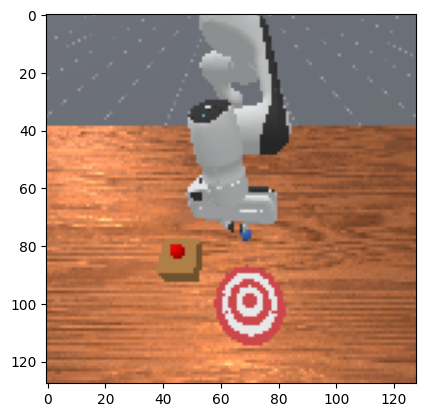

In [4]:
# visualize the image data from the environment and inspect the data
print(obs.keys())
print(obs['sensor_data'].keys())
print(obs['sensor_data']['base_camera'].keys())
print(obs['sensor_data']['base_camera']['rgb'].shape)
import matplotlib.pyplot as plt

plt.imshow(obs['sensor_data']['base_camera']['rgb'][0].cpu().numpy())
plt.show()

In [5]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
# render_mode="sensors" for real observations (rgb+d) or "rgb_array" for external camera
env = gym.make("MyPushCube-v1", num_envs=num_envs, obs_mode="rgb", render_mode="rgb_array")
env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    # on GPU sim we record intervals, not by single episodes as there are multiple envs
    # each 100 steps a new video is saved
    max_steps_per_video=100
)

# step through the environment with random actions
obs, _ = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

2024-11-08 14:10:57,652 - mani_skill  - WARNING - No initial pose set for actor builder of goal_region, setting to default pose q=[1,0,0,0], p=[0,0,0].


goal_region <goal_region: struct of type <class 'mani_skill.utils.structs.actor.Actor'>; managing 1 <class 'sapien.pysapien.Entity'> objects>
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa


2024-11-08 14:10:58,267 - mani_skill  - WARNING - mani_skill is not installed with git.


  0%|          | 0/100 [00:00<?, ?it/s]